In [2]:
#Mendownload dataset
!gdown 1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv -O data/dataset.zip

#Melakukan unzip file dataset
!unzip -q data/dataset.zip -d data/

#Menghapus file zip
!rm -rf data/dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv
From (redirected): https://drive.google.com/uc?id=1LbxDZJu7S4rZMRACX3YX5PKxJ31OR0Xv&confirm=t&uuid=d0e9ab1d-4b05-4553-8a80-db565db08bc5
To: /workspace/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/data/dataset.zip
100%|████████████████████████████████████████| 864M/864M [00:22<00:00, 39.0MB/s]


In [10]:
!python example.py

Pemisahan file gambar berdasarkan class selesai!
Pemisahan dan penggabungan file gambar dari data/ROOT/train dan data/ROOT/test berdasarkan class selesai!
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
Class 'healthy' telah dibagi ke dalam train, val, dan test.
Class 'multiple_diseases' telah dibagi ke dalam train, val, dan test.
Class 'rust' telah dibagi ke dalam train, val, dan test.
Class 'scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!
Class 'Black Rot' telah dibagi ke dalam train, val, dan test.
Class 'Cedar Rust' telah dibagi ke dalam train, val, dan test.
Class 'Healthy' telah dibagi ke dalam train, val, dan test.
Class 'Scab' telah dibagi ke dalam train, val, dan test.
Pembagian dataset selesai!


In [10]:
# 1. **Import Library dan Inisialisasi Konfigurasi**
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

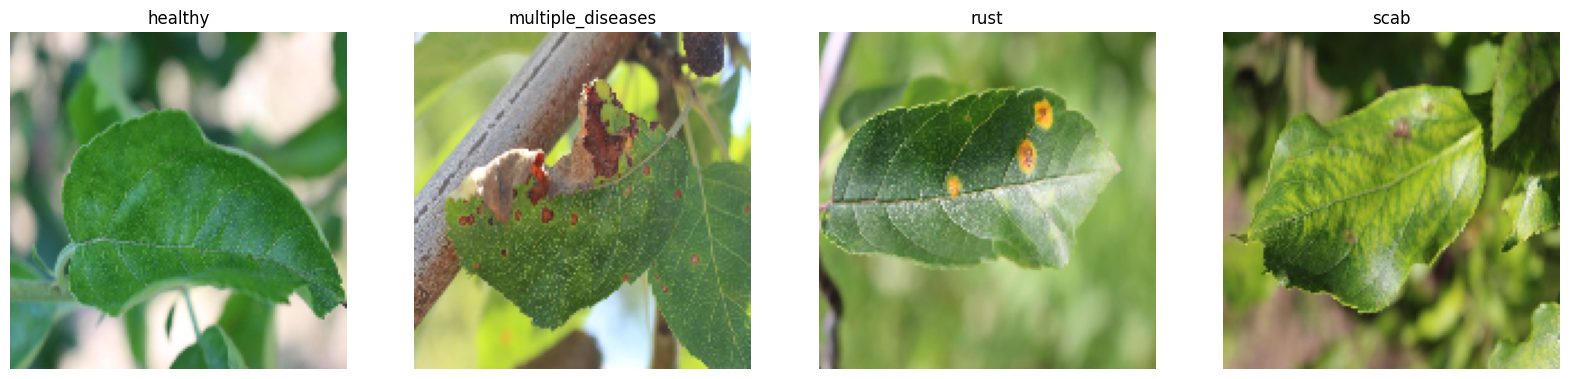

In [12]:
# 2. **Menampilkan Preview Dataset**
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Menampilkan gambar per kelas
base_path = 'data/original_dataset_utama/train'

classes = ['healthy', 'multiple_diseases', 'rust', 'scab']
fig, ax = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(base_path, class_name)
    sample_image = os.listdir(class_folder)[0]
    img_path = os.path.join(class_folder, sample_image)
    img = image.load_img(img_path, target_size=(150, 150))
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(class_name)

plt.show()

In [15]:
# 3. **Persiapan Dataset**
# Dataset akan dibagi menjadi 3 bagian utama: `train`, `validation`, dan `test` dengan rasio 80:10:10.
# Inisialisasi path dataset
base_path = 'data/split_train_test_dataset_utama'
train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'val')
test_dir = os.path.join(base_path, 'test')

# Membuat generator dataset
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)
validation_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_test_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
test_generator = validation_test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 1273 images belonging to 4 classes.
Found 273 images belonging to 4 classes.
Found 275 images belonging to 4 classes.


In [16]:
# 4. **Membangun Model Menggunakan EfficientNet**
# Arsitektur model EfficientNet akan digunakan untuk melakukan klasifikasi penyakit tanaman apel. Penelitian ini menggunakan varian model dari `EfficientNetB0` hingga `EfficientNetB7` serta `EfficientNetV2B0` hingga `EfficientNetV2B3`.

def build_and_compile_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# 5. **Training dan Evaluasi Model**
# Model akan dilatih menggunakan callback `EarlyStopping` dan `ModelCheckpoint` untuk menghentikan pelatihan saat performa tidak meningkat serta menyimpan model terbaik berdasarkan akurasi pada data validasi.

# Callback
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fungsi training model
def train_and_evaluate(model, train_generator, validation_generator, test_generator, epochs=20):
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    # Evaluasi model pada data test
    test_loss, test_acc = model.evaluate(test_generator)
    return history, test_acc

In [18]:
# 6. **Membangun dan Melatih Model untuk Setiap Varian EfficientNet**
# Model akan dilatih untuk setiap varian `EfficientNetB0-B7` dan `EfficientNetV2B0-B3`, kemudian dilakukan evaluasi dan perbandingan performa.

# Daftar varian EfficientNet yang akan diuji
efficientnet_variants = [
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7,
    EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
]

# Dictionary untuk menyimpan hasil performa
performance_results = {}

for variant in efficientnet_variants:
    model_name = variant.__name__
    print(f"Training {model_name}...")
    model = build_and_compile_model(variant, input_shape=(224, 224, 3), num_classes=train_generator.num_classes)
    _, test_acc = train_and_evaluate(model, train_generator, validation_generator, test_generator, epochs=5)
    performance_results[model_name] = test_acc

Training EfficientNetB0...


2024-09-29 12:23:16.533796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:c2:00.0, compute capability: 8.9


Epoch 1/5


2024-09-29 12:23:24.105333: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-29 12:23:24.542769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-09-29 12:23:24.605400: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-09-29 12:23:25.445826: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xbd95f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-29 12:23:25.445850: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-09-29 12:23:25.450126: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-29 12:23:25.547985: I ./tensorflow/compiler/jit/device_compiler.

40/40 [==============================] - ETA: 0s - loss: 1.3044 - accuracy: 0.3071

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 27s 529ms/step - loss: 1.3044 - accuracy: 0.3071 - val_loss: 1.2647 - val_accuracy: 0.3407
Epoch 2/5
40/40 [==============================] - 20s 503ms/step - loss: 1.2769 - accuracy: 0.3001 - val_loss: 1.2599 - val_accuracy: 0.3260
Epoch 3/5
40/40 [==============================] - 20s 503ms/step - loss: 1.2595 - accuracy: 0.3252 - val_loss: 1.2537 - val_accuracy: 0.3407
Epoch 4/5
40/40 [==============================] - 20s 502ms/step - loss: 1.2541 - accuracy: 0.3323 - val_loss: 1.2552 - val_accuracy: 0.2711
Epoch 5/5
9/9 [==============================] - 2s 245ms/step - loss: 1.2445 - accuracy: 0.3236
Training EfficientNetB1...
Epoch 1/5
40/40 [==============================] - 28s 541ms/step - loss: 1.3197 - accuracy: 0.2969 - val_loss: 1.2721 - val_accuracy: 0.3407
Epoch 2/5
40/40 [==============================] - 20s 496ms/step - loss: 1.2694 - accuracy: 0.3142 - val_loss: 1.2625 - val_accuracy: 0.3407
Epoch 3/5
40/40 [=================

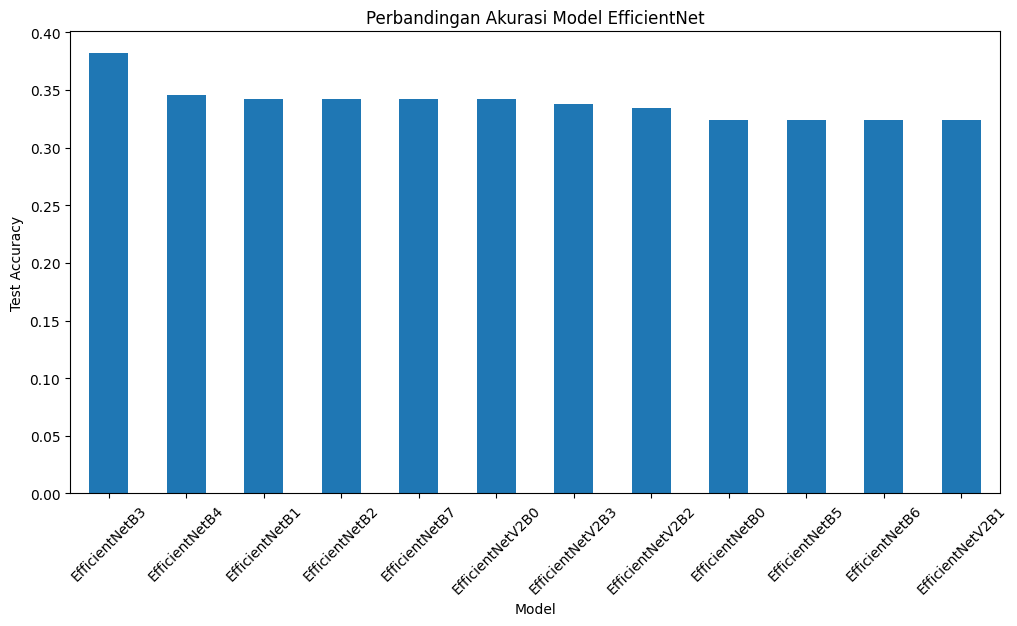

In [19]:
# 7. **Perbandingan Performa Model**
# Setelah semua model dilatih, dilakukan perbandingan performa dengan menampilkan akurasi pada data test untuk setiap varian model.

# Menampilkan hasil performa
performance_df = pd.DataFrame(list(performance_results.items()), columns=['Model', 'Test Accuracy'])
performance_df = performance_df.sort_values(by='Test Accuracy', ascending=False)
performance_df.plot(x='Model', y='Test Accuracy', kind='bar', figsize=(12, 6), legend=False)
plt.title('Perbandingan Akurasi Model EfficientNet')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45)
plt.show()

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
import pandas as pd

# Daftar model EfficientNet yang akan dihitung jumlah layernya
efficientnet_variants = [
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
]

# List untuk menyimpan hasil jumlah layer
model_layers_count = []

# Loop melalui setiap varian dan hitung jumlah layer
for variant in efficientnet_variants:
    model_name = variant.__name__  # Mendapatkan nama model
    model = variant(weights='imagenet')  # Menggunakan weights 'imagenet'
    layer_count = len(model.layers)  # Menghitung jumlah layer
    model_layers_count.append((model_name, layer_count))  # Menyimpan hasil ke list

# Membuat dataframe dari hasil yang diperoleh
df_layers = pd.DataFrame(model_layers_count, columns=['Model', 'Number of Layers'])

# Menampilkan tabel jumlah layer
print(df_layers)

268326632/268326632 [==============================] - 2s 0us/step
            Model  Number of Layers
0  EfficientNetB0               241
1  EfficientNetB1               343
2  EfficientNetB2               343
3  EfficientNetB3               388
4  EfficientNetB4               478
5  EfficientNetB5               580
6  EfficientNetB6               670
7  EfficientNetB7               817
